In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

sb.set()

In [56]:
# https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices

data = pd.read_csv('data/Diamonds Prices2022.csv')

In [77]:
temp_data = pd.read_csv('data/Diamonds Prices2022.csv')

In [57]:
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [93]:
data.describe(include='all')

,carat,cut,color,clarity,price,log_price
count,45624.000000,45624,45624,45624,45624.000000,45624.000000
unique,NaN,5,7,8,NaN,NaN
top,NaN,Ideal,G,SI1,NaN,NaN
freq,NaN,19276,9885,11231,NaN,NaN
mean,0.677412,NaN,NaN,NaN,2865.549163,7.609224
std,0.309142,NaN,NaN,NaN,2427.704609,0.857322
min,0.250000,NaN,NaN,NaN,334.000000,5.811141
25%,0.390000,NaN,NaN,NaN,925.000000,6.829794
50%,0.600000,NaN,NaN,NaN,2029.000000,7.615298
75%,1.000000,NaN,NaN,NaN,4265.000000,8.358197


## Clearing Data

In [92]:
# Column depth and table wasnt linear

data = data.drop(['depth','table', 'Unnamed: 0'],axis=1)

In [60]:
# Getting log values of each price

data['log_price'] = np.log(data['price'])

## Removing outliers

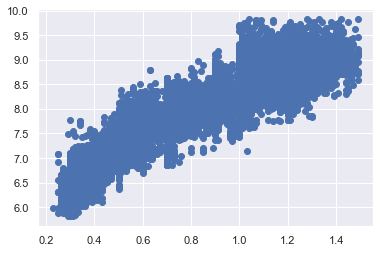

In [69]:
plt.scatter(data['carat'],data['log_price'])

In [68]:
q_carat = data['carat'].quantile(.95)
data = data[data['carat'] < q_carat]

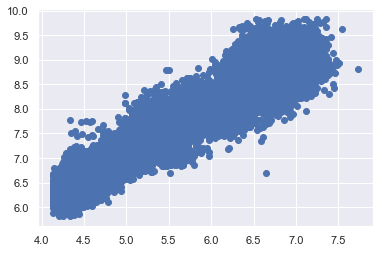

In [70]:
plt.scatter(data['x'],data['log_price'])
plt.show()

In [64]:
q_x = data['x'].quantile(.02)
data = data[data['x'] > q_x]

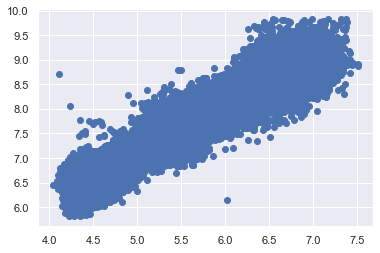

In [71]:
plt.scatter(data['y'],data['log_price'])
plt.show()

In [66]:
q_y = data['y'].quantile(.99)
data = data[data['y'] < q_y]

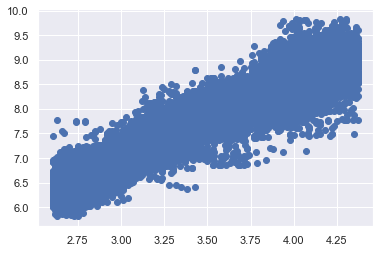

In [76]:
plt.scatter(data['z'],data['log_price'])
plt.show()

In [72]:
q_z = data['z'].quantile(.99)
data = data[data['z'] < q_z]

In [75]:
q_z = data['z'].quantile(.01)
data = data[data['z'] > q_z]

In [86]:
data = data.reset_index(drop=True)

## Checking for multicollinearity

In [87]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = data[['carat','x','y','z']]
vif = [variance_inflation_factor(variables.values,i) for i in range(variables.shape[1])]

vif_table = pd.DataFrame({'Variables': ['carat','x','y','z'], 'VIF': vif})
vif_table

,Variables,VIF
0,carat,13.763870
1,x,11198.512892
2,y,10715.922434
3,z,1850.987351


In [89]:
# dropping x, y, z since their vif is high
data = data.drop(['x','y','z'], axis=1)

## Preprocessing data

In [104]:
data = pd.get_dummies(data,drop_first=True)

## Training and Testing

In [107]:
inputs = data.drop(['price','log_price'], axis=1)
targets = data['log_price']

In [108]:
# scaling the inputs

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(inputs)

scaled_inputs = scaler.transform(inputs)

In [110]:
# splitting data

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(scaled_inputs,targets,random_state=42)

In [111]:
# training model

from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(x_train,y_train)

LinearRegression()

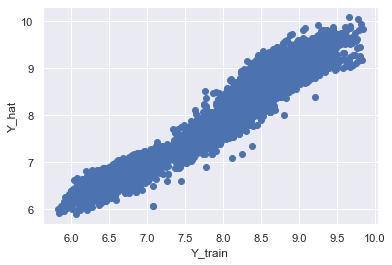

In [115]:
# comparing original and predicted values

y_hat = reg.predict(x_train)

plt.scatter(y_train,y_hat)
plt.xlabel('Y_train')
plt.ylabel('Y_hat')
plt.show()

# as we can see data with higher observation values are not that accurate

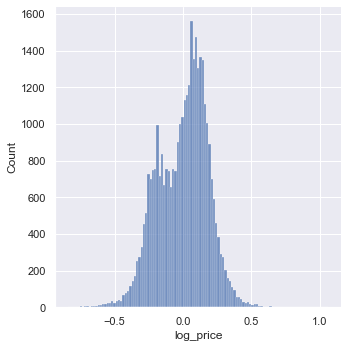

In [117]:
# Residual graph

sb.displot(y_train - y_hat)

## Testing

In [167]:
predicted_values = reg.predict(x_test)

predicted_table = pd.DataFrame({ 'Predicted Values': np.exp(predicted_values), 'Actual Values': np.exp(y_test)})

predicted_table['Residual'] = predicted_table['Actual Values'] - predicted_table['Predicted Values']
predicted_table['Difference%'] = np.absolute((predicted_table['Residual'] / predicted_table['Actual Values']) * 100)

predicted_table.sort_values('Predicted Values')

,Predicted Values,Actual Values,Residual,Difference%
23,348.121595,405.0,56.878405,14.044051
1,352.138099,335.0,-17.138099,5.115850
35937,382.528056,394.0,11.471944,2.911661
7,405.635647,351.0,-54.635647,15.565711
20993,409.662918,367.0,-42.662918,11.624773
...,...,...,...,...
20033,19172.713499,12401.0,-6771.713499,54.606189
19990,20222.238268,12196.0,-8026.238268,65.810415
18455,20307.656183,8740.0,-11567.656183,132.353046
20084,20622.149157,12671.0,-7951.149157,62.750763


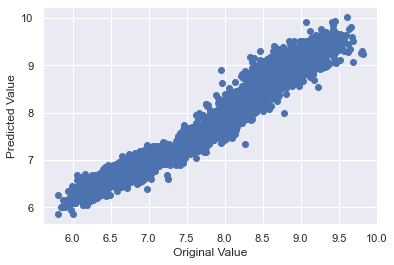

In [168]:
# testing scatter plot

plt.scatter(y_test,predicted_values)
plt.xlabel('Original Value')
plt.ylabel('Predicted Value')
plt.show()

## Low predicted values are more accurate than higher ones

## Model Analysis

In [139]:
n = inputs.shape[0]
p = inputs.shape[1]

r_sqr = reg.score(inputs,targets)
adj_r_sqr = 1 - (1 - r_sqr) * ((n - 1) / (n - p - 1))

analysis = pd.DataFrame({'Feature': ['Bias','R-Square','Adj R-Square'], 'Weights': [reg.intercept_,r_sqr,adj_r_sqr]})

analysis

,Feature,Weights
0,Bias,7.608741
1,R-Square,-0.413552
2,Adj R-Square,-0.414110


## P-Value

In [165]:
from sklearn.feature_selection import f_regression

p_values = f_regression(inputs,targets)

cols = data.drop(['price','log_price'],axis=1).columns.values.tolist()

p_values_table = pd.DataFrame({'Inputs': cols, 'P-Values': p_values[1]})
p_values_table

,Inputs,P-Values
0,carat,0.000000e+00
1,cut_Good,1.835662e-04
2,cut_Ideal,2.861766e-113
3,cut_Premium,1.289840e-23
4,cut_Very Good,2.395917e-25
5,color_E,7.587882e-16
6,color_F,4.024438e-19
7,color_G,5.827722e-03
8,color_H,8.320026e-04
9,color_I,1.117446e-03


# Not the best model so far, but i will improve it in future